# Flow Around a Complex Body

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import xcompact3d_toolbox as x3d

## Parameters

+ Numerical precision

Use `np.float64` if Xcompact3d was compiled with the flag `-DDOUBLE_PREC`, use `np.float32` otherwise.

In [2]:
x3d.param["mytype"] = np.float64

* Xcompact3d's parameters

For more information about them, checkout the [API reference](https://xcompact3d-toolbox.readthedocs.io/en/latest/Docstrings.html#xcompact3d_toolbox.parameters.Parameters).

In [3]:
prm = x3d.Parameters(
    filename="input.i3d",
    itype=12,
    p_row=0,
    p_col=0,
    nx=257,
    ny=129,
    nz=32,
    xlx=15.0,
    yly=10.0,
    zlz=3.0,
    nclx1=2,
    nclxn=2,
    ncly1=1,
    nclyn=1,
    nclz1=0,
    nclzn=0,
    iin=1,
    re=300.0,
    init_noise=0.0125,
    inflow_noise=0.0125,
    dt=0.0025,
    ifirst=1,
    ilast=45000,
    ilesmod=1,
    iibm=2,
    nu0nu=4.0,
    cnu=0.44,
    irestart=0,
    icheckpoint=45000,
    ioutput=200,
    iprocessing=50,
    jles=4,
)

## Setup

### Geometry

Everything needed is in one dictionary of Arrays (see [API reference](https://xcompact3d-toolbox.readthedocs.io/en/latest/Docstrings.html#xcompact3d_toolbox.sandbox.init_epsi)):

In [4]:
epsi = x3d.init_epsi(prm)

The four $\epsilon$ matrices are stored in a dictionary:

In [5]:
epsi.keys()

dict_keys(['epsi', 'xepsi', 'yepsi', 'zepsi'])

Just to exemplify, we can draw and plot a cylinder. Make sure to apply the same operation over all arrays in the dictionary. Plotting a `xarray.DataArray` is as simple as `da.plot()` (see its [user guide](http://xarray.pydata.org/en/stable/plotting.html)), I'm adding extra options just to exemplify how easily we can select one value in $z$ and make a 2D plot:

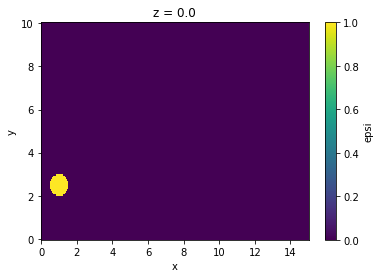

In [6]:
for key in epsi.keys():
    epsi[key] = epsi[key].geo.cylinder(x=1, y=prm.yly / 4.0)

epsi["epsi"].sel(z=0, method="nearest").plot(x="x");

Notice that the geometries are added by default, however, we can revert it by setting `remp=False`. We can execute several methods in a chain, resulting in more complex geometries.

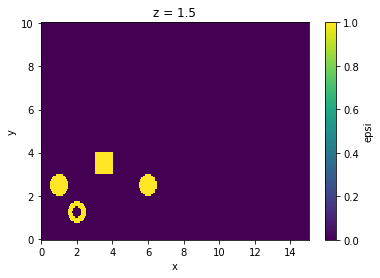

In [7]:
for key in epsi.keys():
    epsi[key] = (
        epsi[key]
        .geo.cylinder(x=2, y=prm.yly / 8.0)
        .geo.cylinder(x=2, y=prm.yly / 8.0, radius=0.25, remp=False)
        .geo.sphere(x=6, y=prm.yly / 4, z=prm.zlz / 2.0)
        .geo.box(x=[3, 4], y=[3, 4])
    )

epsi["epsi"].sel(z=prm.zlz / 2, method="nearest").plot(x="x");

Other example, Ahmed body:

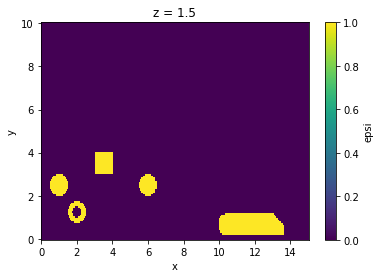

In [8]:
for key in epsi.keys():
    epsi[key] = epsi[key].geo.ahmed_body(x=10, wheels=False)

epsi["epsi"].sel(z=prm.zlz / 2, method="nearest").plot(x="x");

Zooming in:

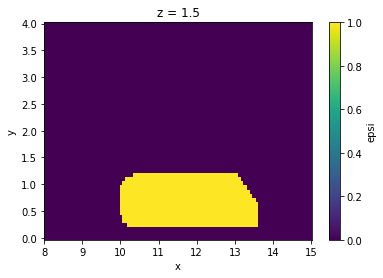

In [9]:
epsi["epsi"].sel(x=slice(8, None), y=slice(None, 4)).sel(
    z=prm.zlz / 2, method="nearest"
).plot(x="x");

And just as an example, we can mirror it:

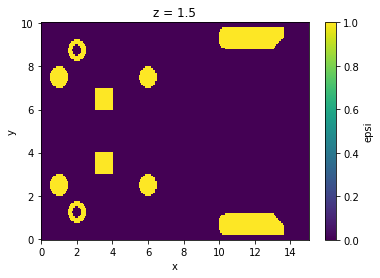

In [10]:
for key in epsi.keys():
    epsi[key] = epsi[key].geo.mirror("y")

epsi["epsi"].sel(z=prm.zlz / 2, method="nearest").plot(x="x");

It was just to show the capabilities of `xcompact3d_toolbox.sandbox`, you can use it to build many different geometries and arrange them in many ways. However, keep in mind the aspects of numerical stability of our Navier-Stokes solver, **it is up to the user to find the right set of numerical and physical parameters**.

For a complete description about the available geometries see [Api reference](file:///C:/Users/felip/Documents/GitHub/Xcompact3d-toolbox/docs/_build/html/Docstrings.html#xcompact3d_toolbox.sandbox.Geometry). Notice that you combine them for the creation of unique geometries, or even create your own routines for your own objects.

So, let's start over with a simpler geometry:

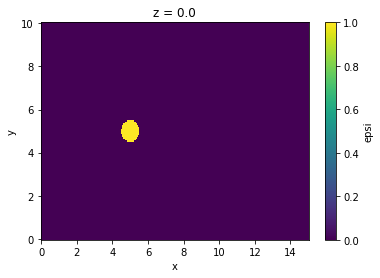

In [11]:
epsi = x3d.sandbox.init_epsi(prm)

for key in epsi.keys():
    epsi[key] = epsi[key].geo.cylinder(x=prm.xlx / 3, y=prm.yly / 2)

epsi["epsi"].sel(z=0, method="nearest").plot(x="x")
plt.show();

The next step is to produce all the auxiliary files describing the geometry, so then Xcompact3d can read them:

In [12]:
%%time
dataset = x3d.gene_epsi_3D(epsi, prm)

prm.nobjmax = dataset.obj.size

dataset

x
       nobjraf : 1
    nobjmaxraf : 1
           bug : 0

y
       nobjraf : 1
    nobjmaxraf : 1
           bug : 0

z
       nobjraf : 1
    nobjmaxraf : 1
           bug : 0

number of points with potential problem in x : 0
number of points with potential problem in y : 0
number of points with potential problem in z : 0

Writing...
Wall time: 6.01 s


<xarray.Dataset>
Dimensions:       (obj_aux: 2, obj: 1, x: 257, y: 129, z: 32)
Coordinates:
  * obj_aux       (obj_aux) int32 -1 0
  * obj           (obj) int32 0
  * x             (x) float64 0.0 0.05859 0.1172 0.1758 ... 14.88 14.94 15.0
  * y             (y) float64 0.0 0.07812 0.1562 0.2344 ... 9.844 9.922 10.0
  * z             (z) float64 0.0 0.09375 0.1875 0.2812 ... 2.719 2.812 2.906
Data variables: (12/28)
    epsi          (x, y, z) bool False False False False ... False False False
    nobj_x        (y, z) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nobjmax_x     int64 1
    nobjraf_x     (y, z) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nobjmaxraf_x  int64 1
    ibug_x        int64 0
    ...            ...
    nxipif_y      (x, z, obj_aux) int64 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2
    nxfpif_y      (x, z, obj_aux) int64 128 2 128 2 128 2 ... 128 2 128 2 128 2
    xi_z          (x, y, obj) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    xf_z          (x, y, obj) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nxipif_z      (x, y, obj_aux) int64 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2
    nxfpif_z      (x, y, obj_aux) int64 31 2 31 2 31 2 31 2 ... 2 31 2 31 2 31 2

### Boundary Condition

Everything needed is in one Dataset (see [API reference](https://xcompact3d-toolbox.readthedocs.io/en/latest/Docstrings.html#xcompact3d_toolbox.sandbox.init_dataset)):

In [13]:
ds = x3d.init_dataset(prm)

Let's see it, data and attributes are attached, try to interact with the icons:

In [14]:
ds

<xarray.Dataset>
Dimensions:       (x: 257, y: 129, z: 32, n: 0)
Coordinates:
  * x             (x) float64 0.0 0.05859 0.1172 0.1758 ... 14.88 14.94 15.0
  * y             (y) float64 0.0 0.07812 0.1562 0.2344 ... 9.844 9.922 10.0
  * z             (z) float64 0.0 0.09375 0.1875 0.2812 ... 2.719 2.812 2.906
  * n             (n) float64 
Data variables:
    bxx1          (y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    bxy1          (y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    bxz1          (y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    noise_mod_x1  (y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ux            (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    uy            (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    uz            (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

**Inflow profile**: Since the boundary conditions for velocity at the top and at the bottom are free-slip in this case (`ncly1=nclyn=1`), the inflow profile for streamwise velocity is just 1 everywhere:

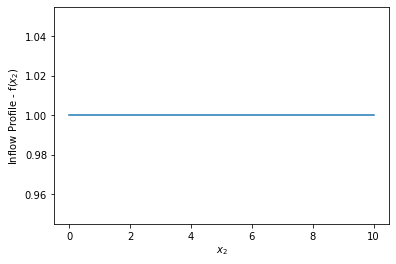

In [15]:
fun = xr.ones_like(ds.y)

# This attribute will be shown in the figure
fun.attrs["long_name"] = r"Inflow Profile - f($x_2$)"

fun.plot();

Now, we reset the inflow planes `ds[key] *= 0.0`, just to guarantee consistency in case of multiple executions of this cell. Notice that `ds[key] = 0.0` may overwrite all the metadata contained in the array, so it should be avoided. Then, we add the inflow profile to the streamwise componente and plot them for reference:

Inflow Plane for Streamwise Velocity


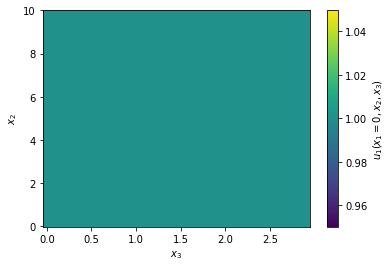

Inflow Plane for Vertical Velocity


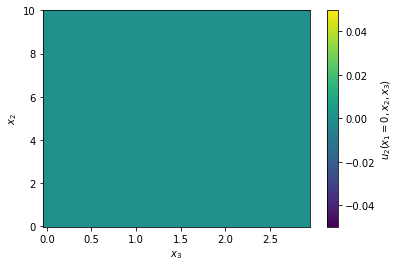

Inflow Plane for Spanwise Velocity


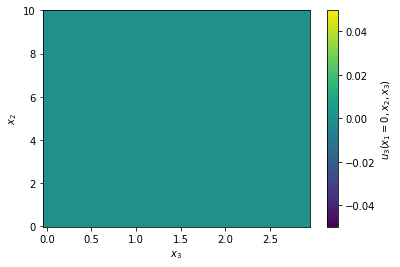

In [16]:
for key in "bxx1 bxy1 bxz1".split():
    #
    print(ds[key].attrs["name"])
    #
    ds[key] *= 0.0
    #
    if key == "bxx1":
        ds[key] += fun
    #
    ds[key].plot()
    plt.show()

plt.close("all")

A random noise will be applied at the inflow boundary, we can create a modulation function `mod` to control were it will be applied. In this case, we will concentrate the noise near the center region and make it zero were $y=0$ and $y=L_y$. The domain is periodic in $z$ `nclz1=nclzn=0`, so there is no need to make `mod` functions of $z$. The functions looks like:

$$
\text{mod} = \exp\left(-0.2 (y - 0.5 L_y)^2 \right).
$$

See the code:

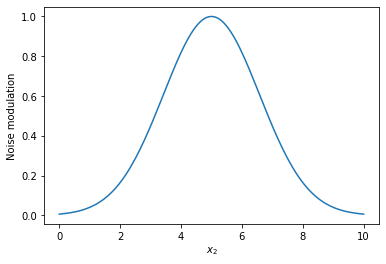

In [17]:
# Random noise with fixed seed,
# important for reproducibility, development and debugging
if prm.iin == 2:
    np.random.seed(seed=67)

mod = np.exp(-0.2 * (ds.y - ds.y[-1] * 0.5) ** 2.0)

# This attribute will be shown in the figure
mod.attrs["long_name"] = "Noise modulation"

mod.plot();

Again, we reset the array `ds['noise_mod_x1'] *= 0.0`, just to guarantee consistency in case of multiple executions of this cell. Notice that `ds['noise_mod_x1'] *= 0.0` may overwrite all the metadata contained in the array, so it should be avoided. Then, we add the modulation profile to the proper array and plot it for reference:

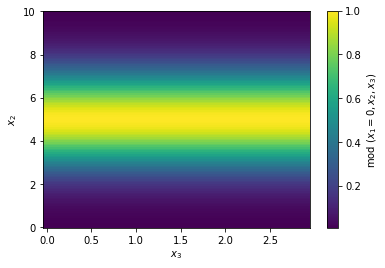

In [18]:
ds["noise_mod_x1"] *= 0.0
ds["noise_mod_x1"] += mod
ds.noise_mod_x1.plot();

Notice one of the many advantages of using [xarray](http://xarray.pydata.org/en/stable/), `mod`, with shape (`ny`), was automatically broadcasted for every point in `z` into `ds.noise_mod_x1`, with shape (`ny`, `nz`).

### Initial Condition

Now we reset velocity fields `ds[key] *= 0.0`, just to guarantee consistency in the case of multiple executions of this cell.

We then add a random number array with the right shape, multiply by the noise amplitude at the initial condition `init_noise` and multiply again by our modulation function `mod`, defined previously. Finally, we add the streamwise profile `fun` to `ux` and make the plots for reference, I'm adding extra options just to exemplify how easily we can slice the spanwise coordinate and produce multiple plots:

Initial Condition for Streamwise Velocity


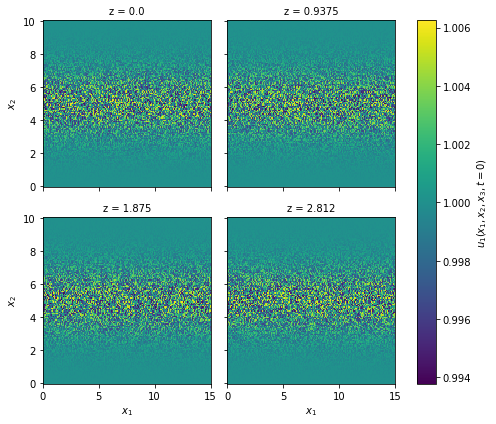

Initial Condition for Vertical Velocity


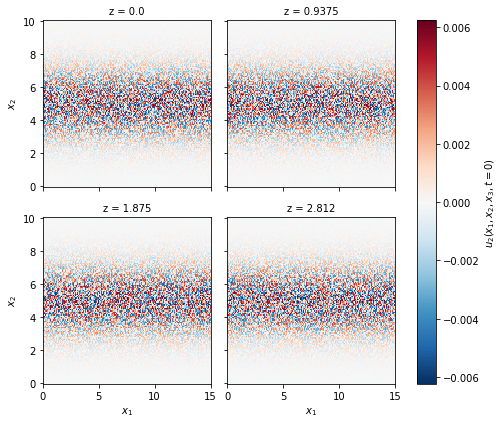

Initial Condition for Spanwise Velocity


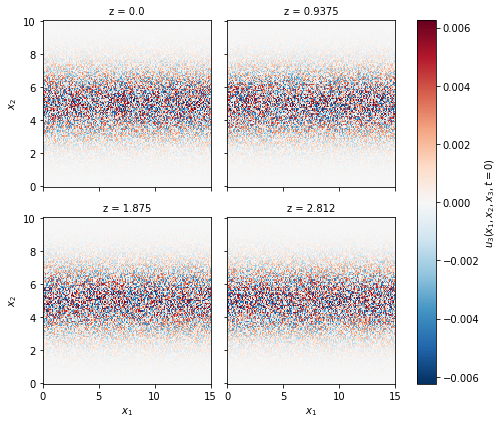

In [19]:
for key in "ux uy uz".split():
    #
    print(ds[key].attrs["name"])
    #
    ds[key] *= 0.0
    ds[key] += prm.init_noise * ((np.random.random(ds[key].shape) - 0.5))
    ds[key] *= mod
    #
    if key == "ux":
        ds[key] += fun
    #
    ds[key].sel(z=slice(None, None, ds.z.size // 3)).plot(
        x="x", y="y", col="z", col_wrap=2
    )
    plt.show()
    #

plt.close("all")

## Writing to disc

is as simple as:

In [20]:
prm.dataset.write(ds)

In [21]:
prm.write()

## Running the Simulation

It was just to show the capabilities of `xcompact3d_toolbox.sandbox`, keep in mind the aspects of numerical stability of our Navier-Stokes solver. **It is up to the user to find the right set of numerical and physical parameters**.

Make sure that the compiling flags and options at `Makefile` are what you expect. Then, compile the main code at the root folder with `make`.

And finally, we are good to go:

```bash
mpirun -n [number of cores] ./xcompact3d |tee log.out
```